### Naver Movie Review Sentiment Analysis
- Word Embedding을 통해 리뷰의 내용이 긍정인지 부정인지 확인하고자 함 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [66.2 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [7]:
import pandas as pd
import numpy as np

import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from collections import Counter
from konlpy.tag import Okt

import re
import os
from os.path import join
from pprint import pprint

In [8]:
root_path = '/content/drive/MyDrive/Colab_Notebook/aiffel_lms/E7_text_sentiment/data'

use_data_path = join(root_path, 'use')

train_data = pd.read_table(join(use_data_path, 'ratings_train.txt'))
test_data = pd.read_table(join(use_data_path, 'ratings_test.txt'))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### Data 특수문자 미리 삭제 

In [9]:
train_data['document'] = train_data['document'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
test_data['document'] = test_data['document'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [10]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


### Data Loader

In [11]:
# Mecab() 분석기 사용 

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 형태소 추출 / 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) 
        temp_x = [word for word in temp_x if not word in stopwords]
        x_test.append(temp_x)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words) # 자주 발생하는 단어에 낮은 인덱스가 할당되는 방식으로 진행 
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    

In [12]:
# 데이터 로드 
# 현재 dict에는 10000-4개의 단어가 포함되어 있음  

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

### Fuctions

#### Encoding & Decoding Dictionary 

In [13]:
# index로 학습 진행한 후, word로 확인하기 위해

index_to_word = {index:word for word, index in word_to_index.items()}

In [14]:
word_to_index.items()

dict_items([('', 3), ('영화', 4), ('다', 5), ('고', 6), ('하', 7), ('을', 8), ('보', 9), ('게', 10), ('지', 11), ('있', 12), ('없', 13), ('좋', 14), ('나', 15), ('었', 16), ('만', 17), ('는데', 18), ('너무', 19), ('봤', 20), ('적', 21), ('안', 22), ('정말', 23), ('로', 24), ('음', 25), ('것', 26), ('아', 27), ('네요', 28), ('재밌', 29), ('어', 30), ('지만', 31), ('같', 32), ('점', 33), ('진짜', 34), ('에서', 35), ('했', 36), ('기', 37), ('네', 38), ('않', 39), ('거', 40), ('았', 41), ('수', 42), ('되', 43), ('면', 44), ('ㅋㅋ', 45), ('인', 46), ('말', 47), ('연기', 48), ('주', 49), ('내', 50), ('최고', 51), ('평점', 52), ('이런', 53), ('던', 54), ('어요', 55), ('할', 56), ('왜', 57), ('겠', 58), ('1', 59), ('스토리', 60), ('해', 61), ('습니다', 62), ('ㅋㅋㅋ', 63), ('듯', 64), ('아니', 65), ('드라마', 66), ('생각', 67), ('더', 68), ('그', 69), ('싶', 70), ('사람', 71), ('때', 72), ('감동', 73), ('배우', 74), ('함', 75), ('본', 76), ('까지', 77), ('뭐', 78), ('알', 79), ('만들', 80), ('내용', 81), ('볼', 82), ('보다', 83), ('라', 84), ('감독', 85), ('재미', 86), ('그냥', 87), ('시간', 88), ('중', 89), ('지

In [15]:
index_to_word.items()

dict_items([(3, ''), (4, '영화'), (5, '다'), (6, '고'), (7, '하'), (8, '을'), (9, '보'), (10, '게'), (11, '지'), (12, '있'), (13, '없'), (14, '좋'), (15, '나'), (16, '었'), (17, '만'), (18, '는데'), (19, '너무'), (20, '봤'), (21, '적'), (22, '안'), (23, '정말'), (24, '로'), (25, '음'), (26, '것'), (27, '아'), (28, '네요'), (29, '재밌'), (30, '어'), (31, '지만'), (32, '같'), (33, '점'), (34, '진짜'), (35, '에서'), (36, '했'), (37, '기'), (38, '네'), (39, '않'), (40, '거'), (41, '았'), (42, '수'), (43, '되'), (44, '면'), (45, 'ㅋㅋ'), (46, '인'), (47, '말'), (48, '연기'), (49, '주'), (50, '내'), (51, '최고'), (52, '평점'), (53, '이런'), (54, '던'), (55, '어요'), (56, '할'), (57, '왜'), (58, '겠'), (59, '1'), (60, '스토리'), (61, '해'), (62, '습니다'), (63, 'ㅋㅋㅋ'), (64, '듯'), (65, '아니'), (66, '드라마'), (67, '생각'), (68, '더'), (69, '그'), (70, '싶'), (71, '사람'), (72, '때'), (73, '감동'), (74, '배우'), (75, '함'), (76, '본'), (77, '까지'), (78, '뭐'), (79, '알'), (80, '만들'), (81, '내용'), (82, '볼'), (83, '보다'), (84, '라'), (85, '감독'), (86, '재미'), (87, '그냥'), (88, '시간'), (89, '중'), (90

In [16]:
# word_to_index, index to word 모두 index 0,1,2를 비워놓음 
# padding 부분과, 문장의 첫 시작, dict에 없는 단어를 확인하기 위함 
index_to_word[0]='<PAD>' 
index_to_word[1]='<BOS>'
index_to_word[2]='<UNK>' 

word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2


In [17]:
# modified dictionary check 
index_to_word[0]

'<PAD>'

In [18]:
# modified dictionary check 
method_1 = {k: v for k, v in sorted(word_to_index.items(), key=lambda item: item[1])}

# Dataframe 형식으로 편하게 보기 
method_2 = pd.DataFrame(list(word_to_index.items()), columns = ['word', 'index'])
method_2.sort_values(by = 'index')

,word,index
9997,<PAD>,0
9998,<BOS>,1
9999,<UNK>,2
0,,3
1,영화,4
...,...,...
9992,그램,9995
9993,총집합,9996
9994,형용,9997
9995,할머님,9998


In [19]:
# 문장 하나, encoding Function
# 모든 문장의 처음은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


# Multiple Sentence Word to Index
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


# 문장 하나, decoding Fuction
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# Multiple Sentence Index to Word
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### Data Preprocessing 

1. Data 확인

In [20]:
# 데이터 확인 : index 형식으로 가져온 것 확인
print(x_train[0])
print(y_train[0])

print(len(x_train), len(y_train), len(x_test), len(y_test)) # train은 145830, test는 49073

[27, 68, 922, 34, 218, 15, 28, 719]
0
145830 145830 49073 49073


2. Max Sentence 길이 확인 
  - pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 꼭 기억
  - 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됨
  - maxlen의 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋음

In [21]:
total_data = list(x_train) + list(x_test)
print(len(total_data)) 

num_tokens_list = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens_list)

print(np.mean(num_tokens)) # 14
print(np.median(num_tokens)) # 11
print(np.max(num_tokens)) # 105
print(np.min(num_tokens)) # 0

194903
14.073374960877976
11.0
105
0


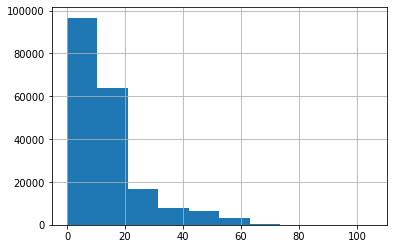

count    194903.000000
mean         14.073375
std          11.638804
min           0.000000
25%           6.000000
50%          11.000000
75%          17.000000
max         105.000000
dtype: float64

In [22]:
# token 길이 graph로 확인 
pd.Series(num_tokens_list).hist()
plt.show()

pd.Series(num_tokens_list).describe()

In [23]:
# 75% 분포를 이용해 maxlen 설정 
max_tokens = np.mean(num_tokens) + 2 * (np.std(num_tokens))
maxlen = int(max_tokens)
maxlen #37

37

In [24]:
# 전체 문장 중 93.5% 이상이 maxlen 설정값 내에 포함됨 
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.935060004207221

maxlen은 37로 setting하고자 함


### Padding 
- RNN을 사용하는 NLP에서는 prepadding이 선호됨
- 마지막 단어가 input으로 들어가기 때문에  

<br>

Embedding 레이어를 활용하여 이전 스텝의 텍스트 데이터를 워드 벡터 텐서 형태로 다시 표현
- raw_inputs 첫번째 code만 진행하면 : Embedding Layer의 인풋이 되는 문장은 길이가 일정해야 함. 
- 즉 raw_inputs 안의 모든 문장은 단어의 개수가 같아야 한다는 것 
- pad 사용 
- `keras.preprocessing.sequence.pad_sequences`는 문장벡터 뒤에 <PAD> 추가하여 길이 일정하게 
- value 옵션은 padding 되는 곳에 어떤 값을 넣을 것인지 설정해주는 것 

In [25]:
x_train = pad_sequences(x_train, value = word_to_index['<PAD>'], 
                        padding = 'pre', maxlen = maxlen)

x_test = pad_sequences(x_test, value = word_to_index['<PAD>'],
                       padding = 'pre', maxlen = maxlen)

In [26]:
# maxlen에 맞는 shape으로 all 변환 

print(x_train.shape, x_test.shape)

(145830, 37) (49073, 37)


TIP
- list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있음

-------------
-------------

### Validation Set 

In [27]:
val_len = len(x_train)*0.2
print(val_len)
print(len(y_train)*0.2)

val_len = int(val_len)

29166.0
29166.0


In [28]:
# Split Train & Validation Set
x_val = x_train[:val_len]
y_val = y_train[:val_len]

x_train = x_train[val_len : ]
y_train = y_train[val_len : ]

print(x_val.shape, x_train.shape)
print(y_val.shape, y_train.shape)

(29166, 37) (116664, 37)
(29166,) (116664,)


### Model 설계 

#### Model_1 : Using LSTM

In [29]:
# LSTM
vocab_size = 10000 # word 사전 10000개
vector_dim = 64

model_1 = keras.Sequential(name = 'model_LSTM')
# shape = (None,)은 모양이 알려지지 않은 수치를 표시할 때 사용됨 
# mask_zero = True : padding 부분 인지시켜주기 위해 진행 
model_1.add(layers.Embedding(vocab_size, vector_dim, input_shape = (None,),
                    mask_zero = True))
model_1.add(layers.Bidirectional(layers.LSTM(units = 128)))
model_1.add(layers.Dense(10, activation = 'relu'))
model_1.add(layers.Dense(1, activation='sigmoid')) # 0, 1로 나와야 해서 sigmoid를 써야할 것 같긴한데... 

model_1.summary()


Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 840,213
Trainable params: 840,213
Non-trainable params: 0
_________________________________________________________________


#### Model_2 : Using LSTM(dropout)

In [30]:
# LSTM_drop
vocab_size = 10000
vector_dim = 64

model_2 = keras.Sequential(name = 'model_LSTM_dropout')
model_2.add(layers.Embedding(vocab_size, vector_dim, input_shape = (None,),
                    mask_zero = True))
model_2.add(layers.Bidirectional(layers.LSTM(units = 128 , dropout = .2, recurrent_dropout = .2 )))
model_2.add(layers.Dense(10, activation = 'relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "model_LSTM_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 840,213
Trainable params: 840,213
Non-trainable params: 0
_________________________________________________________________


#### Model_3 : Using LSTM(dropout & softmax)

In [31]:
# LSTM_drop_softmax
vocab_size = 10000 
vector_dim = 64

model_3 = keras.Sequential(name = 'model_LSTM_drop_softmax')
model_3.add(layers.Embedding(vocab_size, vector_dim, input_shape = (None,),
                    mask_zero = True))
model_3.add(layers.Bidirectional(layers.LSTM(units = 128 , dropout = .2, recurrent_dropout = .2 )))
model_3.add(layers.Dense(10, activation = 'relu'))
model_3.add(layers.Dense(1, activation='softmax'))

model_3.summary()

Model: "model_LSTM_drop_softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 840,213
Trainable params: 840,213
Non-trainable params: 0
_________________________________________________________________


참고페이지 
- https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948


#### Model_4 : Using GRU

In [32]:
vocab_size = 10000 # word 사전 10000개
vector_dim = 64

model_4 = keras.Sequential(name = 'model_GRU')
model_4.add(layers.Embedding(vocab_size, vector_dim, input_shape = (None,),
                    mask_zero = True))
model_4.add(layers.GRU(units = 128 , dropout = .2, recurrent_dropout = .2 ))
model_4.add(layers.Dense(10, activation = 'relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "model_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
gru (GRU)                    (None, 128)               74496     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 715,797
Trainable params: 715,797
Non-trainable params: 0
_________________________________________________________________


### Model_5 : Using CNN

In [37]:
# Model_5 생성

vocab_size = 10000 
word_vector_dim = 64

model_5 = keras.Sequential(name = 'Model_CNN')
model_5.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                input_shape = (None, ), mask_zero = True))
model_5.add(keras.layers.Conv1D(128, 16, activation = 'relu'))
model_5.add(keras.layers.GlobalMaxPool1D())
model_5.add(keras.layers.Dense(10, activation='relu'))
model_5.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_5.summary()

Model: "Model_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         131200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 772,501
Trainable params: 772,501
Non-trainable params: 0
_________________________________________________________________


### Model_6 : Using transformers layer -> 우선 pass


In [ ]:
!pip install transformers

### Model Compile & Fit & Save

In [34]:
# 최적일때 stop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
# epoch 및 batch 설정 
epoch = 30
batch_size = 128

Accuracy를 기준으로 checkpoint 생성
- best point를 h5 file로 저장 
- 지금 model 5개의 학습을 3번에 걸쳐서 돌려서(1&2, 3,4&5) 3개의 h5 파일이 생성됨

In [41]:
# Model_1
# checkpoint 및 earlystoppoint의 monitor와 fit의 metric은 동일해야함 

model_num = 1
file_name = 'checkpoint_epoch_{}_batch_{}_model_{}.h5'.format(epoch, batch_size, model_num)

checkpoint = ModelCheckpoint(file_name, monitor = 'accuracy', verbose = 2,
                             save_best_only = True, mode = 'auto')

earlystoppoint = EarlyStopping(monitor = 'accuracy', patience = 5) #patience를 좀 줄일걸 

model_1.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model_1.summary())

# model fit

history_1 = model_1.fit(x_train, y_train, validation_data = (x_val, y_val), 
                        epochs = epoch, batch_size = batch_size, 
                        callbacks = [checkpoint, earlystoppoint])


Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 840,213
Trainable params: 840,213
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
912/912 [==============================] - 252s 267ms/step - loss: 0.3890 - accuracy: 0.8266 - val_loss: 0.3402 - val_accuracy: 0.8496

Epoch 00001: accuracy improved from -inf to 0.82660, saving model to checkpoint_epoch_30_batch_1

In [42]:
# Model save & test
model_1.save(join(root_path, 'E7_model_1.h5'))

results_1 = model_1.evaluate(x_test,  y_test, verbose=2)
print(results_1)

1534/1534 - 36s - loss: 1.6796 - accuracy: 0.8296
[1.6795769929885864, 0.8295600414276123]


In [34]:
# Model_2

model_num = 2
file_name = 'checkpoint_epoch_{}_batch_{}_model_{}.h5'.format(epoch, batch_size, model_num)

checkpoint2 = ModelCheckpoint(file_name, monitor = 'accuracy', verbose = 2,
                             save_best_only = True, mode = 'auto')

earlystoppoint2 = EarlyStopping(monitor = 'accuracy', patience = 5) #patience를 좀 줄일걸 


model_2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model_2.summary())

history_2 = model_2.fit(x_train, y_train, validation_data = (x_val, y_val), 
                        epochs = epoch, batch_size = batch_size, 
                        callbacks = [checkpoint2, earlystoppoint2])

Model: "Model_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         131200    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 772,501
Trainable params: 772,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
912/912 [==============================] - 41s 13ms/step - loss: 0.3983 - accuracy: 0.8113 - val_loss

In [44]:
# 학습한 후 runtime 종료로 인해 다시 불러옴

model_2.load_weights(join(root_path, 'checkpoint_epoch_30_batch_128_model_2.h5'))

In [38]:
# Model_3
# patience 줄여서 학습 시작 
# 잘못 click해서 결과 say goodbye. 그러나 accuracy 굉장히 낮게 나왔었음 0.5 정도

model_num = 3
file_name = 'checkpoint_epoch_{}_batch_{}_model_{}.h5'.format(epoch, batch_size, model_num)

checkpoint3 = ModelCheckpoint(file_name, monitor = 'accuracy', verbose = 2,
                             save_best_only = True, mode = 'auto')

earlystoppoint3 = EarlyStopping(monitor = 'accuracy', patience = 5) 

model_3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model_3.summary())

history_3 = model_3.fit(x_train, y_train, validation_data = (x_val, y_val), 
                        epochs = epoch, batch_size = batch_size, 
                        callbacks = [checkpoint3, earlystoppoint3])

Model: "model_LSTM_drop_softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 840,213
Trainable params: 840,213
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f1c4df8d290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [41]:
# Model_4

model_num = 4
file_name = 'checkpoint_epoch_{}_batch_{}_model_{}.h5'.format(epoch, batch_size, model_num)

checkpoint4 = ModelCheckpoint(file_name, monitor = 'accuracy', verbose = 2,
                             save_best_only = True, mode = 'auto')

earlystoppoint4 = EarlyStopping(monitor = 'accuracy', patience = 5) 

model_4.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model_4.summary())

history_4 = model_4.fit(x_train, y_train, validation_data = (x_val, y_val), 
                        epochs = epoch, batch_size = batch_size, 
                        callbacks = [checkpoint4, earlystoppoint4])

Model: "model_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
gru (GRU)                    (None, 128)               74496     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 715,797
Trainable params: 715,797
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
912/912 [==============================] - 153s 165ms/step - loss: 0.3835 - accuracy: 0.8321 - val_loss: 0.3439 - val_accuracy: 0.8486

Epoch 00001: accuracy improved from -inf to 0.83211, saving model to checkpoint_epoch_30_batch_12

- model 1, 2보다 낮은 accuracy 보임 

<span style="color:yellow">callback의 checkpoint, earlystoppoint 다 model마다 각자 설정해줘야 실제로 사용이 가능하겠다 인지</span>

In [38]:
# Model_5
# checkpoint 및 earlystoppoint는 model_1과 동일함 
model_num = 5
file_name = 'checkpoint_epoch_{}_batch_{}_model_{}.h5'.format(epoch, batch_size, model_num)

checkpoint5 = ModelCheckpoint(file_name, monitor = 'accuracy', verbose = 2,
                             save_best_only = True, mode = 'auto')

earlystoppoint5 = EarlyStopping(monitor = 'accuracy', patience = 5) 


model_5.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model_5.summary())

# model fit

history_5 = model_5.fit(x_train, y_train, validation_data = (x_val, y_val), 
                        epochs = epoch, batch_size = batch_size, 
                        callbacks = [checkpoint5, earlystoppoint5])

Model: "Model_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         131200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 772,501
Trainable params: 772,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
912/912 [==============================] - 45s 17ms/step - loss: 0.3898 - accuracy: 0.8197 - val_loss

checkpoint & earlystoppoint 참고 : https://teddylee777.github.io/tensorflow/keras-%EC%BD%9C%EB%B0%B1%ED%95%A8%EC%88%98-vol-03

### Model 전체 save

In [ ]:
# model_1.save(join(root_path, 'E7_model_1.h5'))
# model_2.save(join(root_path, 'E7_model_2.h5'))
# model_3.save(join(root_path, 'E7_model_3.h5'))

In [39]:
# model_4.save(join(root_path, 'E7_model_4.h5'))
# model_5.save(join(root_path, 'E7_model_5.h5'))

In [ ]:
# model_1_weight = model_1.load_weights("E7_model_1.h5")
# model_2_weight = model_2.load_weights("E7_model_2.h5")
# model_3_weight = model_3.load_weights("E7_model_3.h5")
# model_4_weight = model_4.load_weights("E7_model_4.h5")
# model_5_weight = model_5.load_weights("E7_model_5.h5")

### Graph로 학습 아이디어 얻기
- model1,2,5만 사용 & 진행

In [78]:
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
# Plot Method_1

def history_plot(history_name, model_name):
    history_dict = history_name.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc)+1)

    fig, ax = plt.subplots(1,2)
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].plot(epochs, val_loss, 'b', label = 'Validation loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc, 'ro', label = 'Training acc')
    ax[1].plot(epochs, val_acc, 'r', label = 'Validation acc')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.suptitle(model_name, fontsize=20)

    plt.show()

In [ ]:
# # Plot Method_2

# def vis(history,name) :
#     plt.title(f"{name.upper()}")
#     plt.xlabel('epochs')
#     plt.ylabel(f"{name.lower()}")
#     value = history.history.get(name)
#     val_value = history.history.get(f"val_{name}",None)
#     epochs = range(1, len(value)+1)
#     plt.plot(epochs, value, 'b-', label=f'training {name}')
#     if val_value is not None :
#         plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
#     plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
# def plot_history(history) :
#     key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
#     plt.figure(figsize=(12, 4))
#     for idx , key in enumerate(key_value) :
#         plt.subplot(1, len(key_value), idx+1)
#         vis(history, key)
#     plt.tight_layout()
#     plt.show()

plot 참고페이지 : https://data-newbie.tistory.com/644

--------
---------

### 학습한 Models을 Word2Vec 형식으로 만듦 | Word2VecKeyedVectors 이용

In [ ]:
#  !pip install gensim == 3.8.3

In [58]:
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

#### Model_1 _ Word2Vec 생성 

In [59]:
embedding_layer_1 = model_1.layers[0]
weights_1 = embedding_layer_1.get_weights()[0]
print(weights_1.shape)    # shape: (vocab_size, embedding_dim)

(10000, 64)


In [61]:
# 학습한 Embedding 파라미터를 write하여 파일에 저장 
word2vec_file_path_1 = join(root_path, 'word2vec_1.txt')
f1 = open(word2vec_file_path_1, 'w')
f1.write('{} {}\n'.format(vocab_size, vector_dim)) 


# 단어 개수 10000개의 워드 벡터를 파일에 기록(< >문자 포함)
vectors1 = model_1.get_weights()[0]
for i in range(0,vocab_size):
    f1.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors1[i, :])))))
f1.close()

In [62]:
# word2vec_1 들고오기

word2vec_mine = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_1, binary=False)

In [64]:
#word2vec 패키지 확인
vector = word2vec_mine['영화']
vector

array([-0.02720558,  0.05660259, -0.09718677,  0.16494884,  0.06101682,
       -0.05755186,  0.02935116,  0.04682359,  0.04432143,  0.08732117,
        0.00751934, -0.02492078, -0.02856544, -0.00612819, -0.11302219,
       -0.02910005,  0.03547359, -0.03876388,  0.14789626,  0.01749439,
       -0.10210567, -0.02629398,  0.00693661, -0.05005178,  0.11824082,
        0.00464731, -0.10318331,  0.02877716, -0.06746715,  0.15147485,
       -0.12857829, -0.12058488,  0.01626531, -0.05598835,  0.16060871,
        0.07972607,  0.12797768,  0.00183492,  0.14319521,  0.02310717,
       -0.09168578, -0.00286361,  0.09998713, -0.0251008 ,  0.02233405,
        0.04041274, -0.11524167,  0.00981642,  0.00314537, -0.02502657,
        0.01779595, -0.04438778,  0.05073783, -0.07750952, -0.00396719,
        0.14839734, -0.00713173,  0.10869856, -0.039334  , -0.14740008,
        0.06436296,  0.03386389,  0.04185395, -0.11302136], dtype=float32)

#### Model_2 _ Word2Vec 생성 

In [66]:
embedding_layer_2 = model_2.layers[0]
weights_2 = embedding_layer_2.get_weights()[0]
print(weights_2.shape)    # shape: (vocab_size, embedding_dim)

(10000, 64)


In [68]:
# 학습한 Embedding 파라미터를 write하여 파일에 저장 
word2vec_file_path_2 = join(root_path, 'ko/ko.bin')
f2 = open(word2vec_file_path_2, 'w')
f2.write('{} {}\n'.format(vocab_size, vector_dim)) 


# 단어 개수 10000개의 워드 벡터를 파일에 기록(< >문자 포함)
vectors2 = model_2.get_weights()[0]
for i in range(0,vocab_size):
    f2.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors2[i, :])))))
f2.close()

In [69]:
# word2vec_2 들고오기

word2vec_mine2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_2, binary=False)

In [73]:
#word2vec 패키지 확인
vector = word2vec_mine2['영화']
vector

array([-0.10195308, -0.17778495,  0.00630154,  0.01549865,  0.09949715,
        0.1652493 , -0.25506037, -0.07690629,  0.08236503,  0.04496053,
       -0.11586308,  0.00415615,  0.06876255, -0.16979063, -0.09522153,
        0.05523648, -0.07432997, -0.1475577 , -0.01525136, -0.05461713,
       -0.11131179, -0.00217426, -0.00871316, -0.08896422,  0.12746404,
        0.01526602, -0.06951655, -0.11488252,  0.03038533, -0.00539643,
        0.0686589 ,  0.04256728, -0.05102964,  0.06784522,  0.01497143,
       -0.04703365,  0.01000274, -0.07843749, -0.1686823 , -0.13532667,
        0.03066035,  0.02273932, -0.0299186 ,  0.10490283,  0.1330655 ,
       -0.00091471, -0.09008346, -0.01825393, -0.20772776,  0.02385543,
       -0.03566461,  0.05633284,  0.02563849,  0.07399575, -0.04187523,
       -0.08208246, -0.10081647, -0.11872657, -0.03499075,  0.10316721,
        0.07887933,  0.07665923, -0.02020802, -0.17429446], dtype=float32)

------------ 여기까지는 모델 생성해서 진행한 것---------------

--------------
---------------

### Model_6 | 한국어 Word2Vec 사용 | from 박규병

In [80]:
# ko.bin 이용 
import gensim

k_word2vec_file_path = join(root_path, 'ko/ko.bin') 
model_6 = gensim.models.Word2Vec.load(k_word2vec_file_path)

In [81]:
result = model_6.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290452718734741), ('거위', 0.7185635566711426), ('토끼', 0.7056223154067993), ('멧돼지', 0.6950401067733765), ('엄마', 0.6934334635734558), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.6750352382659912), ('아빠', 0.6729634404182434), ('목걸이', 0.6512460708618164)]


- 참고 페이지 : https://wikidocs.net/50739

Embedding matrix에 학습된 Word2Vec 사용하기 

In [84]:
vocab_size = 10000 
vector_dim = 200 

# rand 들어간 matrix 생성
embedding_matrix = np.random.rand(vocab_size, vector_dim)

# embedding_matrix에 Word2Vec 단어에 매칭되는 워드벡터를 추가 
for i in range(0,vocab_size):
    if index_to_word[i] in model_6:
        embedding_matrix[i] = model_6[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [93]:
from tensorflow.keras.initializers import Constant

# Word2Vec 이용한 Model_6 구성
# 다른 layers은 위 다른 model 1-5 에서 가장 효율이 좋았던 내역들을 사용   -?>>>>

model_6 = keras.Sequential()
model_6.add(keras.layers.Embedding(vocab_size, 
                                 vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))   # Fine-tuning을 위해
model_6.add(keras.layers.Conv1D(32, 16, activation='relu'))
model_6.add(keras.layers.GlobalMaxPooling1D())
model_6.add(keras.layers.Dense(8, activation='relu'))
model_6.add(keras.layers.Dense(1, activation='sigmoid')) 

model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 37, 200)           2000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 22, 32)            102432    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,102,705
Trainable params: 2,102,705
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_num = 6
batch_size = 512 # 많으니까 높임 

file_name = 'checkpoint_epoch_{}_batch_{}_model_{}.h5'.format(epoch, batch_size, model_num)

checkpoint6 = ModelCheckpoint(file_name, monitor = 'accuracy', verbose = 2,
                             save_best_only = True, mode = 'auto')

earlystoppoint6 = EarlyStopping(monitor = 'accuracy', patience = 5) 

model_6.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model_6.summary())

# model fit

history_6 = model_6.fit(x_train, y_train, validation_data = (x_val, y_val), 
                        epochs = epoch, batch_size = batch_size, 
                        callbacks = [checkpoint6, earlystoppoint6])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 37, 200)           2000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 22, 32)            102432    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,102,705
Trainable params: 2,102,705
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
228/228 [==============================] - 13s 50ms/step - loss: 0.5483 - accuracy: 0.7162 - v

In [95]:
model_6.save(join(root_path, 'E7_model_6.h5'))

### Model 평가 

In [75]:
results_1 = model_1.evaluate(x_test,  y_test, verbose=2)
print(results_1)

1534/1534 - 36s - loss: 1.6796 - accuracy: 0.8296
[1.6795769929885864, 0.8295600414276123]


In [ ]:
# results_2 = model_2.evaluate(x_test,  y_test, verbose=2)
# print(results_2)

In [ ]:
# results_3 = model_3.evaluate(x_test,  y_test, verbose=2)
# print(results_3)

In [ ]:
# results_4 = model_4.evaluate(x_test,  y_test, verbose=2)
# print(results_4)

In [77]:
results_5 = model_5.evaluate(x_test,  y_test, verbose=2)
print(results_5)

1534/1534 - 4s - loss: 1.7738 - accuracy: 0.8293
[1.7738267183303833, 0.8293358683586121]


In [96]:
results_6 = model_6.evaluate(x_test,  y_test, verbose=2)
print(results_6)

1534/1534 - 4s - loss: 1.3189 - accuracy: 0.8189
[1.3189376592636108, 0.8189228177070618]


model_1이 가장 좋은 결과를 보임 

### 개선필요점
- model 학습을 더 빠르게 진행할 수 있는 방법 search 
- model 학습 중간에 멈추거나, runtime이 중단되어도 연속될 수 있는 방법 search 
